In [803]:
import pandas as pd
import matplotlib as plt
import numpy as np
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import seaborn as sns
%matplotlib inline

train_data = pd.read_csv("train_data.csv", index_col = 'Loan_ID')
test_data = pd.read_csv("test_data_modified.csv", index_col = 'Loan_ID') #test_data_modified.csv is a modified version of originally downloaded test file

**Data Exploration of Train data**

*Variable Identification (Data Types,Predictors, Target)*

In [804]:
train_data.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

*Univariate Analysis (Mean, Median, Mode, Std, Max, Min)*

In [805]:
train_data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [806]:
train_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [807]:
train_data['TotalIncome'] = train_data['ApplicantIncome'] + train_data['CoapplicantIncome']
train_data.drop(['ApplicantIncome','CoapplicantIncome'], axis = 1, inplace = True)
train_data.dtypes

Gender               object
Married              object
Dependents           object
Education            object
Self_Employed        object
LoanAmount          float64
Loan_Amount_Term    float64
Credit_History      float64
Property_Area        object
Loan_Status          object
TotalIncome         float64
dtype: object

*Bivariate Analysis*

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13ee61c50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13eea5c90>], dtype=object)

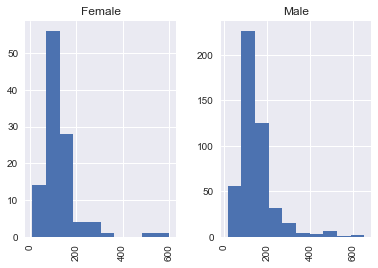

In [808]:
train_data.hist(column = 'LoanAmount', by = 'Gender', bins = 10)

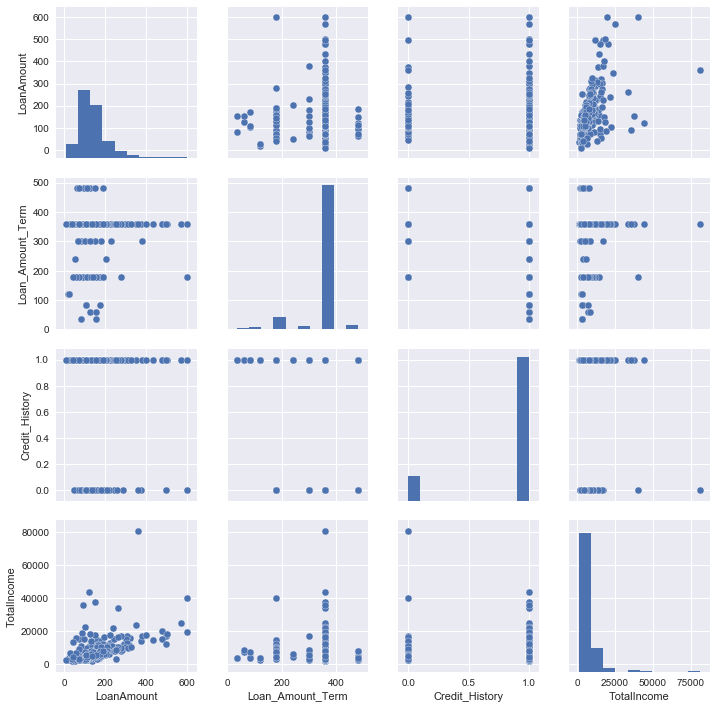

In [809]:
sns.pairplot(train_data.dropna(axis = 0, how = 'any'))

In [810]:
train_data.corr(method='pearson', min_periods=1)

,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome
LoanAmount,1.000000,0.039447,-0.008433,0.624621
Loan_Amount_Term,0.039447,1.000000,0.001470,-0.069948
Credit_History,-0.008433,0.001470,1.000000,-0.015109
TotalIncome,0.624621,-0.069948,-0.015109,1.000000


**Outliers Treatment**

*Printing mean, median, mode*

In [811]:
def mean_median_mode(x):
    return (round(x.mean()),round(x.median()),x.value_counts().index[0])

In [812]:
train_data.select_dtypes(include = ['float64']).apply(mean_median_mode, axis =0)

LoanAmount             (146.0, 128.0, 120.0)
Loan_Amount_Term       (342.0, 360.0, 360.0)
Credit_History               (1.0, 1.0, 1.0)
TotalIncome         (7025.0, 5417.0, 6000.0)
dtype: object

In [813]:
train_data.groupby(['Gender'])['LoanAmount'].mean(), train_data.groupby(['Gender'])['TotalIncome'].mean()

(Gender
 Female    126.697248
 Male      149.265957
 Name: LoanAmount, dtype: float64, Gender
 Female    5751.482143
 Male      7189.392474
 Name: TotalIncome, dtype: float64)

*As the median values are significantly different for Females and Males, we will replace ouliers by Gender specific column median (Education, Self_Employed and Property_Area did not show significant difference in median of the underlying columns, hence only Gender is considered for splitting)*

In [814]:
def replace_outliers_with_median(df,col):
    return df[col].replace( df[df[col]>(df[col].mean()+3*df[col].std())][col] , df[col].median(), inplace = True)

In [815]:
for x in ['Female','Male']:
    df = train_data[train_data['Gender']==x]
    for col in ['LoanAmount','TotalIncome']:
        replace_outliers_with_median(df, col)
    train_data[train_data['Gender']==x] = df

In [816]:
train_data.groupby(['Gender'])['LoanAmount'].mean(), train_data.groupby(['Gender'])['TotalIncome'].mean()

(Gender
 Female    118.715596
 Male      139.848936
 Name: LoanAmount, dtype: float64, Gender
 Female    5414.098214
 Male      6539.815787
 Name: TotalIncome, dtype: float64)

*Mean has reduced after replacing outliers*

In [817]:
train_data.select_dtypes(include = ['float64']).apply(mean_median_mode, axis =0)

LoanAmount             (137.0, 127.0, 130.0)
Loan_Amount_Term       (342.0, 360.0, 360.0)
Credit_History               (1.0, 1.0, 1.0)
TotalIncome         (6446.0, 5407.0, 5666.0)
dtype: object

In [923]:
train_data.LoanAmount[train_data.LoanAmount > np.percentile(train_data.LoanAmount,95)].head()

Loan_ID
LP001011    267.0
LP001020    349.0
LP001046    315.0
LP001100    320.0
LP001186    286.0
Name: LoanAmount, dtype: float64

In [924]:
train_data.LoanAmount[train_data.LoanAmount < np.percentile(train_data.LoanAmount,5)].head()

Loan_ID
LP001030    17.0
LP001086    35.0
LP001120    47.0
LP001138    44.0
LP001275    50.0
Name: LoanAmount, dtype: float64

**Missing Values Treatment**

In [818]:
def count_missing_values(x):
    return sum(x.isnull())

train_data.apply(count_missing_values, axis = 0)

Gender              13
Married              3
Dependents          15
Education            0
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
Property_Area        0
Loan_Status          0
TotalIncome          0
dtype: int64

In [819]:
def replace_missing_values_numericvariable(df,col):
    return df[col].fillna(df[col].median(), inplace = True)
    
def replace_missing_values_categoricalvariable(df,col):
    return df[col].fillna(df[col].value_counts().index[0], inplace = True)

In [820]:
for x in ['Female','Male']:
    df = train_data[train_data['Gender']==x]
    for col in train_data.select_dtypes(include = ['float64']).columns.tolist():
        replace_missing_values_numericvariable(df, col)
    train_data[train_data['Gender']==x] = df
    
for col in train_data.select_dtypes(include = ['object']).columns.tolist():
    replace_missing_values_categoricalvariable(train_data, col)

In [821]:
train_data.apply(count_missing_values, axis = 0)

Gender              0
Married             0
Dependents          0
Education           0
Self_Employed       0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      1
Property_Area       0
Loan_Status         0
TotalIncome         0
dtype: int64

In [822]:
train_data['Credit_History'].fillna(1,inplace = True)

**Data Modelling**

In [823]:
#Changing all categorical variables to numerical variables
le = LabelEncoder()
var_to_encode = train_data.select_dtypes(include = ['object'])
for col in var_to_encode:
    train_data[col] = le.fit_transform(train_data[col])    
    
var_to_encode = test_data.select_dtypes(include = ['object'])
for col in var_to_encode:
    test_data[col] = le.fit_transform(test_data[col])        

#Defining Train and Test Data set
predictors = [x for x in train_data.columns if x != 'Loan_Status']
X_train = train_data[predictors]
y_train = train_data['Loan_Status']
X_test = test_data[predictors]


In [914]:
def modelfit(alg, dtrain, predictors, performCV = True, featureImp = True, cv_folds = 5):
    alg.fit(dtrain[predictors], dtrain['Loan_Status'])
    predictions = alg.predict(dtrain[predictors])
    predictions_prob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross_validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Loan_Status'], cv = cv_folds, scoring = 'roc_auc')
     
    #Print Model Report
    print '\nModel Report:'
    print '\nAccuracy Score: %.4g'% metrics.accuracy_score(dtrain['Loan_Status'].values, predictions)
    print '\nAUC Score: %f'% metrics.roc_auc_score(dtrain['Loan_Status'],predictions_prob)
    print '\nCV Score: %.4g' % np.mean(cv_score)
    
    
    #Print Features Importance
    if featureImp:
        feat_imp = pd.Series(alg.feature_importance_, predictors).sort_values(ascending = False)
        feat_imp.plot(kind = 'bar', title = 'Feature Importance')
        


Model Report:

Accuracy Score: 0.8844

AUC Score: 0.966269

CV Score: 0.7232


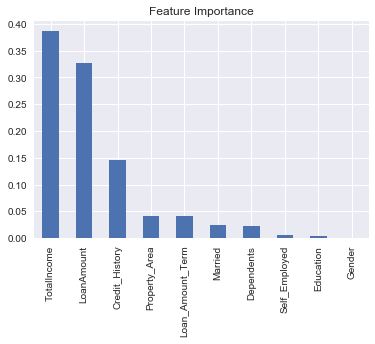

In [825]:
alg = GradientBoostingClassifier(random_state = 10)
modelfit(alg, train_data, predictors)

*Hyperparameter Tuning*

In [857]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=100,
                                  min_samples_leaf=10,max_depth=4,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.74501, std: 0.03408, params: {'n_estimators': 20},
  mean: 0.74235, std: 0.04435, params: {'n_estimators': 30},
  mean: 0.74505, std: 0.04261, params: {'n_estimators': 40},
  mean: 0.73949, std: 0.04438, params: {'n_estimators': 50},
  mean: 0.74548, std: 0.04561, params: {'n_estimators': 60},
  mean: 0.74685, std: 0.04513, params: {'n_estimators': 70},
  mean: 0.74827, std: 0.04340, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 0.7482738791094647)

In [867]:
param_test2 = {'max_depth':range(2,11,2),'min_samples_split':(20,201,20),'min_samples_leaf':range(2,11,2)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt', 
                                n_estimators=80, subsample=0.8, random_state=10),
                       param_grid = param_test2, scoring = 'roc_auc', n_jobs = 4, cv = 5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.75229, std: 0.04413, params: {'min_samples_split': 20, 'max_depth': 2, 'min_samples_leaf': 2},
  mean: 0.76416, std: 0.04157, params: {'min_samples_split': 201, 'max_depth': 2, 'min_samples_leaf': 2},
  mean: 0.75229, std: 0.04413, params: {'min_samples_split': 20, 'max_depth': 2, 'min_samples_leaf': 2},
  mean: 0.75392, std: 0.04653, params: {'min_samples_split': 20, 'max_depth': 2, 'min_samples_leaf': 4},
  mean: 0.76470, std: 0.04181, params: {'min_samples_split': 201, 'max_depth': 2, 'min_samples_leaf': 4},
  mean: 0.75392, std: 0.04653, params: {'min_samples_split': 20, 'max_depth': 2, 'min_samples_leaf': 4},
  mean: 0.75756, std: 0.04411, params: {'min_samples_split': 20, 'max_depth': 2, 'min_samples_leaf': 6},
  mean: 0.76213, std: 0.04169, params: {'min_samples_split': 201, 'max_depth': 2, 'min_samples_leaf': 6},
  mean: 0.75756, std: 0.04411, params: {'min_samples_split': 20, 'max_depth': 2, 'min_samples_leaf': 6},
  mean: 0.75706, std: 0.03460, params: {'min_samples


Model Report:

Accuracy Score: 0.816

AUC Score: 0.863800

CV Score: 0.7648


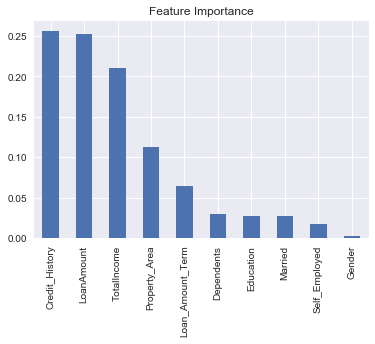

In [878]:
alg = gsearch4.best_estimator_
modelfit(alg,train_data,predictors)

In [916]:
alg = SVC(probability = True, kernel = 'linear')
alg.fit(X_train, y_train)
predictions = alg.predict(X_train)
alg.score(X_train, y_train)

0.77524429967426711

In [ ]:
alg = LogisticRegression()
alg.fit(X_train, y_train)
predictions = alg.predict(X_train)
alg.score(X_train, y_train)

In [906]:
def modelfitsubmit(alg, dtrain, dtest, predictors, performCV = True, featureImp = True, cv_folds = 5):
    alg.fit(dtrain[predictors], dtrain['Loan_Status'])
    predictions = alg.predict(dtest[predictors])
    dtest['Loan_Status'] = predictions
    return dtest['Loan_Status']

In [907]:
SubmissionFile = modelfitsubmit(alg, train_data, test_data, predictors)
SubmissionFile.to_csv("SubmissionFile.csv")